# Imports

In [1]:

from __future__ import division
import numpy as np
import sys
from sys import platform as sys_pf
if sys_pf == 'Darwin':
    import matplotlib
    matplotlib.use("TkAgg")

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import animation
import math
import ar
from sklearn.preprocessing import normalize
import pandas as pd
from pandas import Series, DataFrame, Panel
import seaborn as sns


# Helper Functions

In [2]:
def plot_trajectory_2D(n, is_one, x, y,cxx=None,cyy=None, step=1, scatter_plot=False):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    if is_one:
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = step
    plt.gca().invert_yaxis()
    for index in range(traj_points): 
        for i in range(0,n-s,s):
            if is_one : 
                ax.plot(x[i:i+s+1],y[i:i+s+1],linewidth=3)
            else : 
                
                cx = x[index]
                cy = y[index]
                if (scatter_plot):
                    ax.scatter(cx[i:i+s+1],cy[i:i+s+1],color=(0.0,0.0,T[index]))
                else:
                    ax.plot(cx[i:i+s+1],cy[i:i+s+1],linewidth=3,color=(0.0,0.0,T[index]))
    if (cxx is not None):
        n=cxx.shape[1]
        for index in range(traj_points): 
            for i in range(0,n-s,s):
                if is_one : 
                    ax.plot(x[i:i+s+1],y[i:i+s+1],linewidth=3)
                else : 

                    cx = cxx[index]
                    cy = cyy[index]
                    if (scatter_plot):
                        ax.scatter(cx[i:i+s+1],cy[i:i+s+1],color=(T[index],0.0,0.0))
                    else:
                        ax.plot(cx[i:i+s+1],cy[i:i+s+1],linewidth=3,color=(0.0,0.0,T[index]))

    
    plt.show()

In [3]:
def plot_trajectory_3D(n, is_one, x, y, z, step=1):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    
    fig = plt.figure() 
    ax = fig.add_subplot(111, projection='3d')
    plt.gca().invert_yaxis()
    

    if is_one :
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    s = step
    for index in range(traj_points):
        for j in range(0, n-s, s):
            if is_one :             
                ax.plot(x[j:j+s+1],y[j:j+s+1],z[j:j+s+1],linewidth=2)
            else : 
                cx = x[index]
                cy = y[index]
                cz = z
                ax.plot(cx[j:j+s+1],cy[j:j+s+1],cz[j:j+s+1],linewidth=2,color=(0.0,0.0,T[index]))


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

In [4]:
def predict(X, A,order=2,predict_states=1,guided = True):
    
    # This is somewhat tricky. For abitrary order, we need to
    # come up with an expression for:
    #
    # Xrecon = SUM_OF_PREVIOUS_TERMS
    #
    # where SUM_OF_PREVIOUS_TERMS is constructed in a loop over "order"
    # previous elements in the data, multiplying each element by the
    # corresponding transition matrix/coefficient. Then that sum needs to be
    # but a single element in a larger array that has a correspondence to
    # the original X.
    Xnext = np.zeros((X.shape[0],X.shape[1]+predict_states))
    Xnext[:, :order] = X[:, :order]
    
    
    #Assuming np.size(X, axis = 1) = order
    for p in range(np.size(X, axis = 1),np.size(X, axis = 1)+predict_states):
        for j in range(0, order):
            # The second argument to np.dot() is a ternary statement, conditioning
            # on the "guided" boolean passed into this method: do we use the actual
            # data in estimating the next point, or previously-esimated data?
            
            Xnext[:, p] += np.dot(A[j], Xnext[:, p - j - 1] if guided else Xnext[:, p - j -1])
    
    
    orig_X = Xnext[:,:order]
    next_X = Xnext[:,order:]
    Xnext_mean = Xnext - np.mean(Xnext, axis = 0)
    return orig_X, next_X, Xnext, Xnext_mean
    

# Normal Cells

### Read inputs

In [5]:
normal_cells_files = [
        '/media/narita/Data/Neutrophils/fps_20_frames/1_07052016_Phagocytosis/final' \
                      '/tracking/organized_kalman_output_center_coords.npy',
        '/media/narita/Data/Neutrophils/fps_20_frames/5_07072016_Phagocytosis_DMSO/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'


]

all_normal_cells = []
for i in range(len(normal_cells_files)):
    normal_input = np.load(normal_cells_files[i])
    all_normal_cells.insert(i,normal_input)

all_normal_cells = np.vstack(all_normal_cells) 


### Trajectory Plots

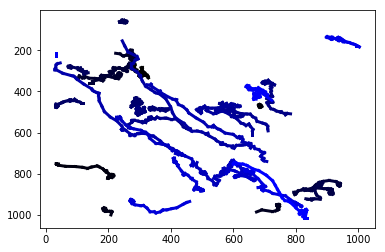

In [6]:
#%matplotlib notebook
is_one = False
plot_trajectory_2D(all_normal_cells.shape[1],is_one,all_normal_cells[:,:,0],all_normal_cells[:,:,1])


### AR

#### Normalize Inputs

In [7]:
all_normal_cells_copy = all_normal_cells.copy()
all_normal_cells_copy = np.transpose(all_normal_cells_copy,(1,0,2))
all_normal_cells_copy = all_normal_cells_copy.reshape(all_normal_cells_copy.shape[0],all_normal_cells_copy.shape[1]*all_normal_cells_copy.shape[2])

all_normal_cells_norm,normal_norms = normalize(all_normal_cells_copy,axis=0,return_norm=True)


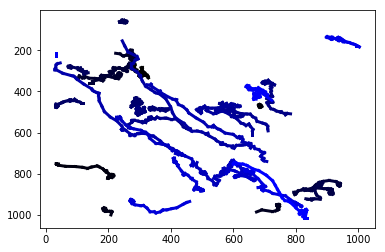

In [8]:
# If needed, plot again
recon = all_normal_cells_norm*normal_norms
recon = recon.reshape(all_normal_cells_copy.shape[0],int(all_normal_cells_copy.shape[1]/2),2)
recon = np.transpose(recon,(1,0,2))
plot_trajectory_2D(recon.shape[1],False,recon[:,:,0],recon[:,:,1])



#### State Space reduction - PCA

In [9]:
pca_components = 3
ar_order = 2
normal_X,normal_C,normal_S,normal_U = ar.state_space(all_normal_cells_norm.T,pca_components)


#### Variance of components

In [ ]:
tot = sum(normal_S)
var_exp = [(i / tot) * 100 for i in sorted(normal_S, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print ((var_exp))

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

#### Plotting components

In [ ]:
# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_X[0,:], normal_X[1,:], normal_X[2,:],  c='r', marker='o')
ax.set_xlabel('pc1');ax.set_ylabel('pc2');ax.set_zlabel('pc3');

plt.show()

In [ ]:
#2D Plot
%matplotlib inline

fig, ax = plt.subplots(1,3, sharey=True, sharex= True, figsize=(10,3))
ax[0].scatter(normal_X[0,:],normal_X[1,:]);ax[0].set_xlabel('pc1');ax[0].set_ylabel('pc2')
ax[1].scatter(normal_X[1,:],normal_X[2,:]);ax[1].set_xlabel('pc2');ax[1].set_ylabel('pc3')
ax[2].scatter(normal_X[0,:],normal_X[2,:]);ax[2].set_xlabel('pc1');ax[2].set_ylabel('pc3')


In [ ]:
#2D Plot
%matplotlib inline

if (pca_components/2)==0:
    fig, ax = plt.subplots(int(pca_components/2),2,sharex= True, figsize=(15,5))
else:
    fig, ax = plt.subplots(pca_components-1,2,sharex= True, figsize=(15,5))

for i in range(pca_components):
    r = int(i/2)
    c = int(i%2)
    ax[r,c].scatter(range(len(normal_X[i,:])),normal_X[i,:]);ax[r,c].set_ylabel('pc'+str(i))
    

#### AR Train

In [10]:
normal_X_train = normal_X[:,:]
#X_test = X[:,50:]

Feature Vector:
[[[ 1.3128857  -0.24891886 -0.19081638]
  [ 0.08206611  1.28362492  0.13552041]
  [-0.31262047  0.35770549  1.34413182]]

 [[-0.3129542   0.25528996  0.19065356]
  [-0.07719794 -0.30243181 -0.11976076]
  [ 0.30912037 -0.32234325 -0.37917876]]]


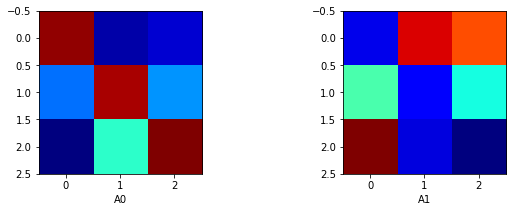

In [11]:
%matplotlib inline 

is_plot=True
normal_A, normal_Q = ar.train(normal_X_train, order = ar_order)

# Feature Vector
feature_vector = np.array(normal_A).flatten()
print ('Feature Vector:')
print (np.array(normal_A))

# Plot AR
if (is_plot):
    fig, ax = plt.subplots(1,len(normal_A), figsize=(10,3))
    for i in range(len(normal_A)):
        if (len(normal_A) > 1):
            ax[i].imshow(normal_A[i], cmap = "jet")
            ax[i].set_xlabel('A'+str(i))
        else:
            ax.imshow(normal_A[i], cmap = "jet")
            ax.set_xlabel('A'+str(i))


#### Test AR

In [ ]:
Y = ar.test(X_test,A)
err = (ar.error(Y,X_test))
print (np.mean(err))

# MRS Videos

### Read Inputs

In [12]:
mrs_cells_files = [
        '/media/narita/Data/Neutrophils/fps_20_frames/2_07052016_Phagocytosis_MRS2578/final'\
                  '/tracking/organized_kalman_output_center_coords.npy',
        '/media/narita/Data/Neutrophils/fps_20_frames/6_07072016_Phagocytosis_MRS2578/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'


]

all_mrs_cells = []
for i in range(len(mrs_cells_files)):
    mrs_input = np.load(mrs_cells_files[i])
    all_mrs_cells.insert(i,mrs_input)

all_mrs_cells = np.vstack(all_mrs_cells) 


### Trajectory Plots

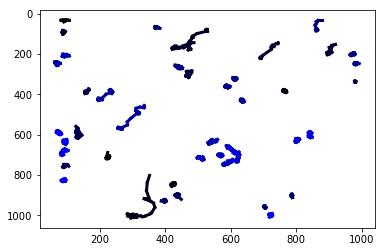

In [13]:
#%matplotlib notebook
plot_trajectory_2D(all_mrs_cells.shape[1],False,all_mrs_cells[:,:,0],all_mrs_cells[:,:,1])


### AR

#### Normalize Input

In [14]:
all_mrs_cells_copy = all_mrs_cells.copy()
all_mrs_cells_copy = np.transpose(all_mrs_cells_copy,(1,0,2))
all_mrs_cells_copy = all_mrs_cells_copy.reshape(all_mrs_cells_copy.shape[0],all_mrs_cells_copy.shape[1]*all_mrs_cells_copy.shape[2])

all_mrs_cells_norm,mrs_norms = normalize(all_mrs_cells_copy,axis=0,return_norm=True)


In [ ]:
# If needed, plot again
mrs_recon = all_mrs_cells_norm*norms
mrs_recon = mrs_recon.reshape(all_mrs_cells_norm.shape[0],int(all_mrs_cells_norm.shape[1]/2),2)
mrs_recon = np.transpose(mrs_recon,(1,0,2))
plot_trajectory_2D(mrs_recon.shape[1],False,mrs_recon[:,:,0],mrs_recon[:,:,1])



#### State Space Reduction

In [15]:
mrs_X,mrs_C,mrs_S,mrs_U = ar.state_space(all_mrs_cells_norm.T, pca_components)

#### Variance of components

In [ ]:
tot = sum(mrs_S)
var_exp = [(i / tot) * 100 for i in sorted(mrs_S, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print ((var_exp))

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

#### Plotting components after PCA

In [ ]:
# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mrs_X[0,:], mrs_X[1,:], mrs_X[2,:],  c='r', marker='o')
ax.set_xlabel('pc1');ax.set_ylabel('pc2');ax.set_zlabel('pc3');

plt.show()

In [ ]:
#2D Plot
%matplotlib inline

fig, ax = plt.subplots(1,3, sharey=True, sharex= True, figsize=(10,3))
ax[0].scatter(mrs_X[0,:],mrs_X[1,:]);ax[0].set_xlabel('pc1');ax[0].set_ylabel('pc2')
ax[1].scatter(mrs_X[1,:],mrs_X[2,:]);ax[1].set_xlabel('pc2');ax[1].set_ylabel('pc3')
ax[2].scatter(mrs_X[0,:],mrs_X[2,:]);ax[2].set_xlabel('pc1');ax[2].set_ylabel('pc3')


In [ ]:
#2D Plot
%matplotlib inline

fig, ax = plt.subplots(1,3,sharex= True, figsize=(15,3))

for i in range(3):
    ax[i].scatter(range(len(mrs_X[i,:])),mrs_X[i,:]);ax[i].set_xlabel('frames');ax[i].set_ylabel('pc'+str(i))
    

#### AR Train

In [16]:
mrs_X_train = mrs_X[:,:]
#mrs_X_test = mrs_X[:,50:]

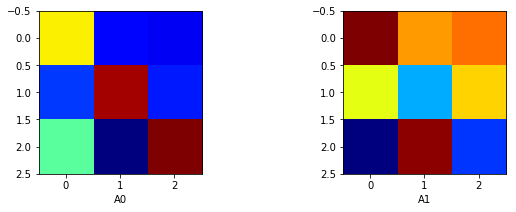

In [17]:
is_plot=True
mrs_A, mrs_Q = ar.train(mrs_X_train, order = ar_order)

# Feature Vector
feature_vector = np.array(mrs_A).flatten()
#print ('Feature Vector:')
#print (np.array(mrs_A))

# Plot AR
if (is_plot):
    fig, ax = plt.subplots(1,len(mrs_A), figsize=(10,3))
    for i in range(len(mrs_A)):
        if (len(mrs_A) > 1):
            ax[i].imshow(mrs_A[i], cmap = "jet")
            ax[i].set_xlabel('A'+str(i))
        else:
            ax.imshow(mrs_A[i], cmap = "jet")
            ax.set_xlabel('A'+str(i))


#### AR Test

In [ ]:
Y = ar.test(mrs_X_test, A)
err = ar.error(Y,mrs_X_test)
np.mean(err)

# Histograms of components of normal, mrs

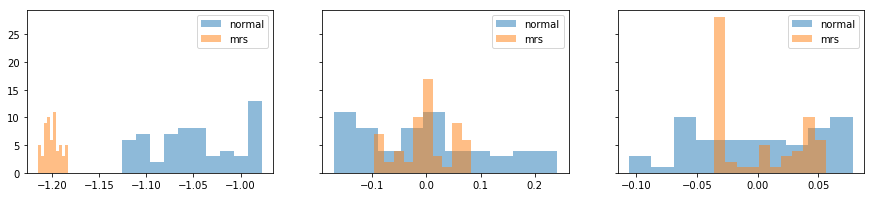

In [18]:
%matplotlib inline
pcs = mrs_X.shape[0]
f, axarr = plt.subplots(1, pcs,sharey=True, figsize=(15,3))

for i in range(pcs):
    axarr[i].hist(normal_X[i,:],bins=10, alpha=0.5, label='normal')
    axarr[i].hist(mrs_X[i,:],bins=10, alpha=0.5, label='mrs')
    axarr[i].legend(loc='upper right')
plt.show()


# Noise covariance matrix Q of normal, mrs

In [19]:
print (normal_Q)
print ('')
print (mrs_Q)

[[ 0.01628149  0.0081875   0.01811215]
 [ 0.0081875   1.0864067   1.09774752]
 [ 0.01811215  1.09774752  1.12209067]]

[[ 0.00312511  0.00588422  0.00704732]
 [ 0.00588422  1.44361875  1.44396029]
 [ 0.00704732  1.44396029  1.44791512]]


/home/narita/anaconda2/envs/pytorchenv/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


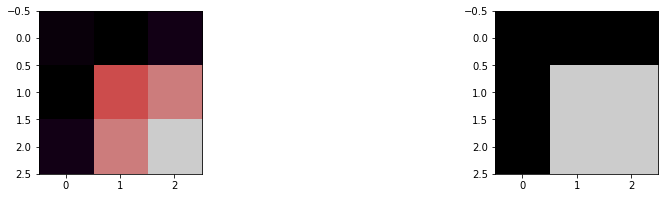

In [20]:
%matplotlib inline

f, axarr = plt.subplots(1, 2,figsize=(15,3))
axarr[0].imshow(normal_Q,cmap='spectral')
axarr[1].imshow(mrs_Q,cmap='spectral')

In [21]:
def get_eigens(z,is_plot=False):
    cov_mat = z
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    print('Eigenvectors \n%s' % eig_vecs)
    print('\nEigenvalues \n%s' % eig_vals)

    for ev in eig_vecs:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    print('Everything ok!')
    print ('')

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    #Visually confirm that the list is correctly sorted by decreasing eigenvalues
    print('Eigenvalues in descending order:')
    for i in eig_pairs:
        print(i[0])

    tot = sum(eig_vals)
    var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    print ((var_exp))

    if (is_plot):
        with plt.style.context('seaborn-whitegrid'):
            plt.figure(figsize=(6, 4))

            plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.step(range(len(var_exp)), cum_var_exp, where='mid',
                     label='cumulative explained variance')
            plt.ylabel('Explained variance ratio')
            plt.xlabel('Principal components')
            plt.legend(loc='best')
            plt.tight_layout()
        plt.show()




In [22]:
print ('Normal')
get_eigens(normal_Q)
print ('')

print ('Abnormal')
get_eigens(mrs_Q)

Normal
Eigenvectors 
[[-0.00853267 -0.88866304 -0.4584814 ]
 [-0.70129306  0.3321575  -0.630761  ]
 [-0.71282203 -0.31614775  0.62604741]]

Eigenvalues 
[ 2.20230036  0.01966475  0.00281375]
Everything ok!

Eigenvalues in descending order:
2.20230035799
0.0196647462492
0.00281375410519
[98.98962990096048, 0.8838966702473704, 0.12647342879214141]

Abnormal
Eigenvectors 
[[-0.0031679  -0.90016493 -0.43553766]
 [-0.70657642  0.31021737 -0.63601489]
 [-0.70762965 -0.30572582  0.63701806]]

Eigenvalues 
[  2.88975779e+00   3.49077771e-03   1.41040695e-03]
Everything ok!

Eigenvalues in descending order:
2.88975779415
0.00349077770669
0.00141040694738
[99.830681793953502, 0.12059374635340304, 0.048724459693104565]


# Synthesize

### Multi-Step Out-of-Sample Forecast

This forecast randomly selects a starting point and forecasts predict_states time steps ahead in the sequence from the available data used to fit the model.

#### Intialize Vars

In [27]:
cls = 'mrs'
if (cls == 'normal'):
    input_X = normal_X_train
    A = normal_A
    Q = normal_Q
    C = normal_C
    norm = normal_norms
    

else:
    
    input_X = mrs_X_train
    A = mrs_A
    Q = mrs_Q
    C = mrs_C
    norm = mrs_norms



predict_states = 10

In [28]:
import random

selected_index = random.randrange(0, 5, 1)
print (selected_index)

X_subsample = input_X[:,selected_index:selected_index+2]
orig_X, predicted_X,orig_predicted,orig_recon = predict(X_subsample,A,predict_states=predict_states)

print (orig_X.shape)
print (predicted_X.shape)
print (orig_predicted.shape)

3
(3, 2)
(3, 10)
(3, 12)


#### Just making sure that the predictions are from the same subspace

In [ ]:
%matplotlib inline

X_in_copy = input_X.T.copy()
f, axarr = plt.subplots(1, predicted_X.shape[0],figsize=(15,3),sharex=True)
for i in range(predicted_X.shape[0]):
    X_in = X_in_copy[:,i]
    pc = list(predicted_X[i,:])
    axarr[i].hist(X_in,alpha=0.5)
    axarr[i].set_xlabel('component_'+(str(i+1)))
    axarr[i].scatter(pc,np.ones(len(pc)),color='r')

plt.show()


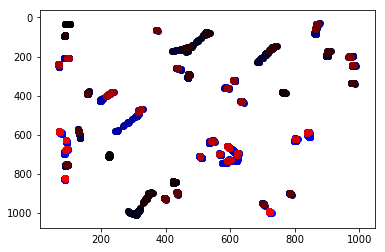

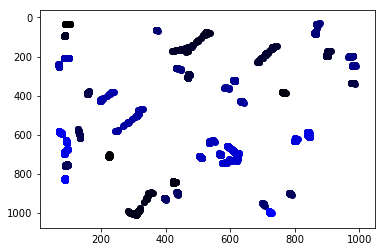

In [29]:
X_train_copy = input_X.copy()
orig_pixel_space = ar.appearance_space(X_train_copy,C)

orig_image_space = (orig_pixel_space.T * norm).T
orig_image_space = np.reshape(orig_image_space,(int(orig_image_space.shape[0]/2),2,orig_image_space.shape[1]))
orig_image_space = np.transpose(orig_image_space,(0,2,1))

predicted_copy = orig_predicted.copy()
predicted_pixel_space = ar.appearance_space(predicted_copy,C)
predicted_image_space = (predicted_pixel_space.T * norm).T
predicted_image_space = np.reshape(predicted_image_space,(int(predicted_image_space.shape[0]/2),2,predicted_image_space.shape[1]))
predicted_image_space = np.transpose(predicted_image_space,(0,2,1))

frame_num = orig_image_space.shape[1]
is_one = False
currentX = orig_image_space[:,:,0]
currentY = orig_image_space[:,:,1]


cxx = predicted_image_space[:,:,0]
cyy = predicted_image_space[:,:,1]


plot_trajectory_2D(frame_num,is_one,currentX,currentY,cxx,cyy,scatter_plot=True)
plot_trajectory_2D(frame_num,is_one,currentX,currentY,None,None,scatter_plot=True)




In [30]:
predicted_outputs = predicted_image_space.copy()
path = '/media/narita/Data/Neutrophils/fps_20_frames/average_motion_model' \
                      '/ar_generated_center_coords_'+cls+'.npy'

np.save(path,predicted_outputs)
print (path+' saved!')

/media/narita/Data/Neutrophils/fps_20_frames/average_motion_model/ar_generated_center_coords_mrs.npy saved!


### One-Step Out-of-Sample Forecast

A one-step forecast is a forecast of the very next time step in the sequence from the available data used to fit the model.

In [ ]:
total_frames = input_X.shape[1]
selected_index = total_frames - ar_order 
print (selected_index)

X_subsample = input_X[:,selected_index:selected_index+2]
orig_X, predicted_X,orig_predicted,orig_recon = predict(X_subsample,A,predict_states=1)

print (orig_X.shape)
print (predicted_X.shape)
print (orig_predicted.shape)

In [ ]:
X_train_copy = input_X.copy()
orig_pixel_space = ar.appearance_space(X_train_copy,C)

orig_image_space = (orig_pixel_space.T * norm).T
orig_image_space = np.reshape(orig_image_space,(int(orig_image_space.shape[0]/2),2,orig_image_space.shape[1]))
orig_image_space = np.transpose(orig_image_space,(0,2,1))

predicted_copy = orig_predicted.copy()
predicted_pixel_space = ar.appearance_space(predicted_copy,C)
predicted_image_space = (predicted_pixel_space.T * norm).T
predicted_image_space = np.reshape(predicted_image_space,(int(predicted_image_space.shape[0]/2),2,predicted_image_space.shape[1]))
predicted_image_space = np.transpose(predicted_image_space,(0,2,1))

frame_num = orig_image_space.shape[1]
is_one = False
currentX = orig_image_space[:,:,0]
currentY = orig_image_space[:,:,1]


cxx = predicted_image_space[:,:,0]
cyy = predicted_image_space[:,:,1]


plot_trajectory_2D(frame_num,is_one,currentX,currentY,cxx,cyy,scatter_plot=True)
plot_trajectory_2D(frame_num,is_one,currentX,currentY,None,None,scatter_plot=True)


